# **Load and Preprocess Training Data:**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer

# Paths to datasets
train_data_path = r"/content/sample_data/MultiLanguageTrainDataset.csv"

# Load data
data = pd.read_csv(train_data_path)

#print columns
print("Columns")
print(data.columns)

# Preprocessing: Handle missing values
data.dropna(subset=["text", "label", "language"], inplace=True)

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'].tolist(), data['label'].tolist(), test_size=0.1, random_state=42
)

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


Columns
Index(['Unnamed: 0', 'text', 'label', 'language'], dtype='object')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
# Convert labels to integers
train_labels = [int(label) for label in train_labels]
val_labels = [int(label) for label in val_labels]

# Prepare Dataset for PyTorch:

In [ ]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are 1D for CrossEntropyLoss
        return item

# Create datasets
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


# **Fine-Tune XLM-Roberta:**

In [4]:
from transformers import XLMRobertaForSequenceClassification, Trainer, TrainingArguments

# Load model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="epoch",
    save_total_limit=2,
    report_to=["tensorboard"]  # Enable TensorBoard
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train
trainer.train()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.600600,0.527222
2,0.466400,0.597044


Epoch,Training Loss,Validation Loss
1,0.600600,0.527222
2,0.466400,0.597044
3,0.372600,0.585571


TrainOutput(global_step=4389, training_loss=0.4876563697340386, metrics={'train_runtime': 862.9653, 'train_samples_per_second': 40.674, 'train_steps_per_second': 5.086, 'total_flos': 9235198043136000.0, 'train_loss': 0.4876563697340386, 'epoch': 3.0})

# **Test Model on Multilingual Data**:

In [ ]:
import pandas as pd
from transformers import Trainer
from sklearn.metrics import ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

# Paths to test datasets
test_files = [
    r"/content/sample_data/test/Arabic_test.csv",
    r"/content/sample_data/test/Chinese_test.csv",
    r"/content/sample_data/test/English_test.csv",
    r"/content/sample_data/test/French_test.csv",
    r"/content/sample_data/test/German_test.csv",
    r"/content/sample_data/test/Indonesian_test.csv",
    r"/content/sample_data/test/Italian_test.csv",
    r"/content/sample_data/test/Korean_test.csv",
    r"/content/sample_data/test/Porto_test.csv",
    r"/content/sample_data/test/Rurdu_test.csv",
    r"/content/sample_data/test/Russian_test.csv",
    r"/content/sample_data/test/Spain_test.csv",
    r"/content/sample_data/test/Turkish_test.csv"
]

for test_file in test_files:
    try:
        # Check if the file exists
        if not os.path.exists(test_file):
            print(f"File not found: {test_file}")
            continue

        # Load and preprocess test data
        test_data = pd.read_csv(test_file)
        if test_data.empty:
            print(f"Skipping empty dataset: {test_file}")
            continue

        # Ensure required columns exist
        if 'text' not in test_data.columns or 'label' not in test_data.columns:
            print(f"Required columns missing in {test_file}")
            continue

        test_texts = test_data['text'].tolist()
        test_labels = test_data['label'].tolist()

        # Tokenize test data
        test_encodings = tokenizer(
            test_texts, truncation=True, padding=True, max_length=512
        )
        test_dataset = MultilingualDataset(test_encodings, test_labels)

        # Evaluate using the trainer
        results = trainer.evaluate(test_dataset)

        # Print evaluation results
        print(f"\n=== Results for {os.path.basename(test_file)} ===")
        print(results)

        # If confusion matrix is available in results
        if "confusion_matrix" in results:
            cm = results["confusion_matrix"]
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Offensive", "Offensive"])
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix for {os.path.basename(test_file)}")
            plt.show()
    except Exception as e:
        print(f"Error processing {test_file}: {e}")



=== Results for Arabic_test.csv ===
{'eval_loss': 1.1856657266616821, 'eval_accuracy': 0.7796976241900648, 'eval_precision': 0.7267080745341615, 'eval_recall': 0.6685714285714286, 'eval_f1': 0.6964285714285714, 'eval_runtime': 0.9066, 'eval_samples_per_second': 510.724, 'eval_steps_per_second': 63.978, 'epoch': 3.0}

=== Results for Chinese_test.csv ===
{'eval_loss': 1.1087895631790161, 'eval_accuracy': 0.7770345596432553, 'eval_precision': 0.6822742474916388, 'eval_recall': 0.6601941747572816, 'eval_f1': 0.6710526315789473, 'eval_runtime': 6.1637, 'eval_samples_per_second': 145.529, 'eval_steps_per_second': 18.333, 'epoch': 3.0}

=== Results for English_test.csv ===
{'eval_loss': 0.7219241857528687, 'eval_accuracy': 0.854893328818151, 'eval_precision': 0.884472049689441, 'eval_recall': 0.787030213706706, 'eval_f1': 0.8329108988106844, 'eval_runtime': 40.585, 'eval_samples_per_second': 145.522, 'eval_steps_per_second': 18.209, 'epoch': 3.0}

=== Results for French_test.csv ===
{'eval_

In [ ]:
# Save model
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

# Load model
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
model = XLMRobertaForSequenceClassification.from_pretrained("./saved_model")
tokenizer = XLMRobertaTokenizer.from_pretrained("./saved_model")

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get predicted labels
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Add the metrics computation
)

# Train the model
trainer.train()

# Evaluate on the validation set
results = trainer.evaluate()
print("Validation Metrics:", results)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.377500,1.042424,0.776154,0.774554,0.646182,0.704569
2,0.277500,1.170162,0.760000,0.831858,0.525140,0.643836
3,0.216900,1.017749,0.786923,0.757937,0.711359,0.733910


Validation Metrics: {'eval_loss': 1.0177490711212158, 'eval_accuracy': 0.786923076923077, 'eval_precision': 0.7579365079365079, 'eval_recall': 0.7113594040968343, 'eval_f1': 0.733909702209414, 'eval_runtime': 8.78, 'eval_samples_per_second': 148.063, 'eval_steps_per_second': 18.565, 'epoch': 3.0}


In [ ]:
# Save the trained model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/sentencepiece.bpe.model',
 './saved_model/added_tokens.json')

In [ ]:
for test_file in test_files:
    # Load and preprocess test data
    test_data = pd.read_csv(test_file)
    test_texts = test_data['text'].tolist()
    test_labels = test_data['label'].tolist()

    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
    test_dataset = MultilingualDataset(test_encodings, test_labels)

    # Evaluate
    predictions = trainer.predict(test_dataset)
    metrics = compute_metrics(predictions)
    print(f"Metrics for {test_file}: {metrics}")


Metrics for /content/sample_data/test/Arabic_test.csv: {'accuracy': 0.7796976241900648, 'precision': 0.7267080745341615, 'recall': 0.6685714285714286, 'f1': 0.6964285714285714}


Metrics for /content/sample_data/test/Chinese_test.csv: {'accuracy': 0.7770345596432553, 'precision': 0.6822742474916388, 'recall': 0.6601941747572816, 'f1': 0.6710526315789473}


Metrics for /content/sample_data/test/English_test.csv: {'accuracy': 0.854893328818151, 'precision': 0.884472049689441, 'recall': 0.787030213706706, 'f1': 0.8329108988106844}


Metrics for /content/sample_data/test/French_test.csv: {'accuracy': 0.7857793983591613, 'precision': 0.8033088235294118, 'recall': 0.7734513274336283, 'f1': 0.78809738503156}


Metrics for /content/sample_data/test/German_test.csv: {'accuracy': 0.619235836627141, 'precision': 0.6734505087881592, 'recall': 0.47550620509470937, 'f1': 0.557427258805513}


Metrics for /content/sample_data/test/Indonesian_test.csv: {'accuracy': 0.8466211085801063, 'precision': 0.8172268907563025, 'recall': 0.7718253968253969, 'f1': 0.7938775510204081}


Metrics for /content/sample_data/test/Italian_test.csv: {'accuracy': 0.7763671875, 'precision': 0.680672268907563, 'recall': 0.6787709497206704, 'f1': 0.6797202797202797}


Metrics for /content/sample_data/test/Korean_test.csv: {'accuracy': 0.7164556962025317, 'precision': 0.7789203084832905, 'recall': 0.6870748299319728, 'f1': 0.7301204819277108}


Metrics for /content/sample_data/test/Porto_test.csv: {'accuracy': 0.7469879518072289, 'precision': 0.6369047619047619, 'recall': 0.4553191489361702, 'f1': 0.5310173697270472}


Metrics for /content/sample_data/test/Rurdu_test.csv: {'accuracy': 0.7423913043478261, 'precision': 0.7945205479452054, 'recall': 0.7546468401486989, 'f1': 0.7740705433746425}


Metrics for /content/sample_data/test/Russian_test.csv: {'accuracy': 0.8573200992555832, 'precision': 0.8362445414847162, 'recall': 0.7118959107806692, 'f1': 0.7690763052208835}


Metrics for /content/sample_data/test/Spain_test.csv: {'accuracy': 0.7514078841512469, 'precision': 0.6706231454005934, 'recall': 0.5330188679245284, 'f1': 0.5939553219448095}


Metrics for /content/sample_data/test/Turkish_test.csv: {'accuracy': 0.8169353344450621, 'precision': 0.5575342465753425, 'recall': 0.37966417910447764, 'f1': 0.45172031076581576}


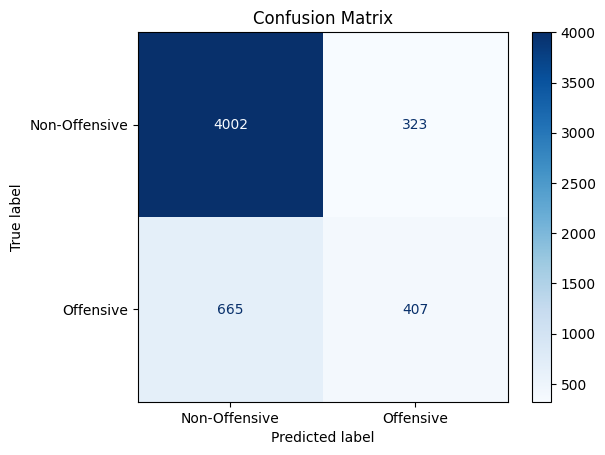

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(
    labels, preds, display_labels=["Non-Offensive", "Offensive"], cmap="Blues"
)
plt.title("Confusion Matrix")
plt.show()